In [1]:
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = os.path.join('morse_dataset', 'morse_dataset')
PREPROCESS = False
TRAIN = True
DEBUG = False

In [3]:
import torchaudio.transforms as T
from normalize import Normalize

def build_transform():
    return torch.nn.Sequential(
        T.Spectrogram(n_fft=1024, hop_length=256, power=2.0),
        Normalize()
    )

In [4]:
waveform, sample_rate = torchaudio.load(os.path.join(DATASET_PATH, '1.opus'))

transform = build_transform()
spec = transform(waveform)

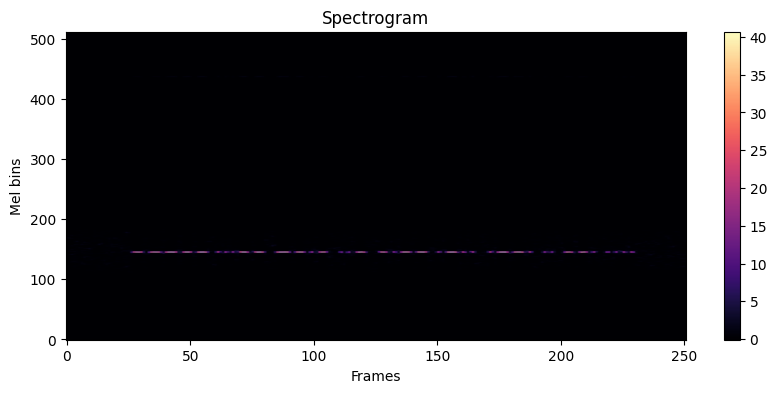

In [5]:
plt.figure(figsize=(10, 4))
plt.imshow(spec[0,:,:].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar()
plt.show()

In [6]:
from preprocessing import preprocess_dataset

df = pd.read_csv('train.csv')
transform = build_transform()
labels_dict = {
        f"{row['id']}": row['message']
        for _, row in df.iterrows()
    }

if PREPROCESS:
    preprocess_dataset(DATASET_PATH, "data_preprocessed", labels_dict, transform)

In [7]:
from preprocessed_dataset import PreprocessedDataset

c2i = {
    '<blank>': 0,
    '.': 1,
    '-': 2,
    ' ': 3,
    '/': 4
}
i2c = {v: k for k, v in c2i.items()}

train_dataset = PreprocessedDataset('data_preprocessed/train', c2i)
val_dataset = PreprocessedDataset('data_preprocessed/val', c2i)

In [8]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, targets, input_lengths, target_lengths = zip(*batch)

    features = [f.transpose(0, 1) for f in features]

    padded_features = pad_sequence(features, batch_first=True)
    padded_targets = torch.cat(targets)

    input_lengths = torch.tensor([f.shape[0] for f in features], dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return padded_features, padded_targets, input_lengths, target_lengths

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

In [10]:
from morse_conformer import MorseConformer
from train import train
from cv import cross_val_scores

model = MorseConformer(input_dim=513, output_dim=len(c2i))

if TRAIN:
    if DEBUG:
        scores = cross_val_scores(model, train_dataset, train, collate_fn, num_epochs=100, patience=5)
    
        print(f'Scores: {scores}')
        print(f'Mean: {np.mean(scores)}')
        print(f'Std: {np.std(scores)}')

    train(model=model, train_loader=train_loader, val_loader=val_loader, num_epochs=100, patience=5)
else:
    model.load_state_dict(torch.load('models/best_model.pt', map_location='cuda'))

[Epoch 1] train loss: 2.2266 | val loss: 1.1997


[Epoch 2] train loss: 1.1807 | val loss: 1.1881


[Epoch 3] train loss: 1.1662 | val loss: 1.1750


[Epoch 4] train loss: 0.9927 | val loss: 0.5295


[Epoch 5] train loss: 0.2239 | val loss: 0.1162


[Epoch 6] train loss: 0.1021 | val loss: 0.0775


[Epoch 7] train loss: 0.0737 | val loss: 0.0665


[Epoch 8] train loss: 0.0591 | val loss: 0.0555


[Epoch 9] train loss: 0.0513 | val loss: 0.0502


[Epoch 10] train loss: 0.0448 | val loss: 0.0481


[Epoch 11] train loss: 0.0415 | val loss: 0.0478


[Epoch 12] train loss: 0.0365 | val loss: 0.0435


[Epoch 13] train loss: 0.0340 | val loss: 0.0415


[Epoch 14] train loss: 0.0313 | val loss: 0.0412


[Epoch 15] train loss: 0.0293 | val loss: 0.0431


[Epoch 16] train loss: 0.0281 | val loss: 0.0413


[Epoch 17] train loss: 0.0260 | val loss: 0.0411


[Epoch 18] train loss: 0.0246 | val loss: 0.0402


[Epoch 19] train loss: 0.0237 | val loss: 0.0439


[Epoch 20] train loss: 0.0227 | val loss: 0.0398


[Epoch 21] train loss: 0.0215 | val loss: 0.0441


[Epoch 22] train loss: 0.0212 | val loss: 0.0439


[Epoch 23] train loss: 0.0193 | val loss: 0.0418


[Epoch 24] train loss: 0.0187 | val loss: 0.0411


[Epoch 25] train loss: 0.0176 | val loss: 0.0429


In [11]:
from torchaudio.models.decoder import ctc_decoder

labels = list(c2i.keys())
decoder = ctc_decoder(
    lexicon=None,
    tokens=labels,
    beam_size=10,
    blank_token='<blank>',
    unk_word='<blank>',
    sil_token='<blank>'
)

In [12]:
from preprocessing import preprocess_audio
import os
import torch
import torchaudio
import pandas as pd
from preprocessing import decode_from_morse
from torch.nn.functional import log_softmax

model.eval()
submission = []

audio_dir = DATASET_PATH
target_files = sorted([
    f for f in os.listdir(audio_dir)
    if f.endswith('.opus') and 30001 <= int(os.path.splitext(f)[0]) <= 35000
], key=lambda x: int(os.path.splitext(x)[0]))

with torch.no_grad():
    for fname in target_files:
        path = os.path.join(audio_dir, fname)
        mel = preprocess_audio(path, transform)
        mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
        input_len = torch.tensor([mel.shape[1]], device='cuda')

        logits = model(mel)
        log_probs = log_softmax(logits, dim=-1)
        log_probs_btc = log_probs.transpose(0, 1)
        
        decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
        decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
        decoded_text = decode_from_morse(decoded_morse)

        submission.append({
            "id": fname,
            "message": decoded_text
        })

df = pd.DataFrame(submission)
df.to_csv("submission.csv", index=False)

In [13]:
from torch.nn.functional import log_softmax
from torch.nn import CTCLoss
import editdistance

model.eval()
ctc_loss_fn = CTCLoss(blank=0, zero_infinity=True)
val_losses = []
levenshtein_scores = []

with torch.no_grad():
    for features, targets, input_lengths, target_lengths in val_loader:
        features = features.to('cuda')
        targets = targets.to('cuda')
        input_lengths = input_lengths.to('cuda')
        target_lengths = target_lengths.to('cuda')
        
        log_probs = model(features, input_lengths)
        log_probs = log_softmax(log_probs, dim=-1)
        
        loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)
        val_losses.append(loss.item())
        
        log_probs_btc = log_probs.transpose(0, 1)
        
        decoded_output = decoder(log_probs_btc.cpu().contiguous(), input_lengths.cpu())
        decoded_batch = [''.join([labels[token.item()] for token in hypo[0].tokens]) for hypo in decoded_output]
        target_batch = []
        start = 0
        
        for length in target_lengths:
            length = int(length)
            target_seq = targets[start:start + length]
            text = ''.join([i2c[int(c)] for c in target_seq])
            target_batch.append(text)
            start += length
        
        for pred, true in zip(decoded_batch, target_batch):
            dist = editdistance.eval(decode_from_morse(pred), decode_from_morse(true))
            levenshtein_scores.append(dist)

mean_val_loss = sum(val_losses) / len(val_losses)
mean_levenshtein = sum(levenshtein_scores) / len(levenshtein_scores)

print(f"Val CTC Loss: {mean_val_loss:.4f}")
print(f"Mean Levenshtein: {mean_levenshtein:.4f}")

Val CTC Loss: 0.0427
Mean Levenshtein: 0.4064


In [15]:
total_files = 35000
sr = 8000
duration_sec = 8
max_samples = sr * duration_sec

for file in range(total_files - 16, total_files + 1):
    path = os.path.join(audio_dir, f'{file}.opus')

    waveform, sample_rate = torchaudio.load(path)
    waveform = waveform[:, :max_samples]

    mel = transform(waveform).squeeze(0)
    mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
    input_len = torch.tensor([mel.shape[1]], device='cuda')

    logits = model(mel)
    log_probs = log_softmax(logits, dim=-1)
    log_probs_btc = log_probs.transpose(0, 1)

    decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
    decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
    decoded_text = decode_from_morse(decoded_morse)

    print(f"{file}.opus,{decoded_text}")

34984.opus,ДАГДАМТ СОТИ РСН
34985.opus,ИЛ ЬСВЕДТКЧВНТИ
34986.opus,АНХ ВСОЕГЬ Р ВКТ
34987.opus,ИЛ ДАСДП ЬСОЕМУ
34988.opus,ЕТЬТКП ДСЯНКМЫМ
34989.opus,КНОЬКМ СОЕНЫМО
34990.opus,ИЛ ЬСОЕНДМЫМ ЙН
34991.opus,ИЛ ДАСДП ОСЮВЕ
34992.opus,АС АТ ИСЧТИ КГ
34993.opus,ОЫДЛ МЫР
34994.opus,АН ЖНОЕСЕТ ЬТКТЕ
34995.opus,ОДЦЮП ЬСВВТКТ
34996.opus,ОРСКС ИЛ ДАСДП
34997.opus,ОИСЧТИ СЕЬКНДМЕИ
34998.opus,ТОЫМ ДЛ ЬС
34999.opus,ОДТЕ ОСЫАЯН А
35000.opus,РСАТЯ ЬТКТВНЖМ
